# Drossel-Schwabl Forest Fire Model
Simulation to demonstrate criticality in Drossel-Schwabl Forest Fire Model (DSFFM).

References:
- [1] B. Drossel and F. Schwabl, “Self-organized critical forest-fire model,” Phys. Rev. Lett., vol. 69, no. 11, pp. 1629–1632, 1992, doi: 10.1103/PhysRevLett.69.1629.
- [2] S. Clar, B. Drossel, and F. Schwabl, “Forest fires and other examples of self-organized criticality,” J. Phys.: Condens. Matter, vol. 8, no. 37, pp. 6803–6824, 1996, doi: 10.1088/0953-8984/8/37/004.
- [3] Clar, S., Drossel, B., & Schwabl, F. (1994). Scaling laws and simulation results for the self-organized critical forest-fire model. Physical Review E, 50(2), 1009-1018. doi:10.1103/PhysRevE.50.1009.

## Mechanism:

During one time step, the system is parallely updated according to the following rules 
- Empty site (0) $\rightarrow$ tree with probability p.
- Tree (1) $\rightarrow$ burning tree with probability 1−g if at least one nearest neighbour is burning (g=0 in this version of simulation, i.e. no immunity to fire). 
- Tree (1) $\rightarrow$ burning tree with probability f if no nearest neighbour is burning. 
- Burning tree (2) $\rightarrow$ empty site (spontaneiously).
When lightning strucks a tree, identify the entire cluster and set it to burn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import label, center_of_mass
from scipy.stats import linregress
from joblib import Parallel, delayed # for parallel computing
import json

# Define constants
EMPTY = 0
TREE = 1
BURNING = 2

# Plot setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'  # Use the Computer Modern Roman font
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['axes.titlesize'] = 20  # Title
plt.rcParams['xtick.labelsize'] = 14 # X tick labels
plt.rcParams['ytick.labelsize'] = 14 # Y tick labels

In [5]:
def update_lattice(lattice, p, f):
    N = lattice.shape[0]
    new_lattice = lattice.copy()
    num_sites = int(p/f)
    
    # Helper: randomly select a site from lattice
    def random_sites(N, k):
        # Ensure k is not greater than the total number of sites
        if k > N * N:
            raise ValueError("k cannot be greater than the total number of sites in the lattice.")

        # Generate k unique random indices from 0 to N*N-1
        indices = np.random.choice(N * N, k, replace=False)

        # Convert indices to (row, column) coordinates
        sites = [(index // N, index % N) for index in indices]
        return sites

    # Helper: Mark entire clusters as burning
    def burn_cluster(i, j):
        stack = [(i, j)]
        while stack:
            x, y = stack.pop()
            if new_lattice[x, y] == TREE:
                new_lattice[x, y] = BURNING  # Set to burning
                # Check neighbors
                if x > 0 and new_lattice[x-1, y] == TREE:
                    stack.append((x-1, y))
                if x < N-1 and new_lattice[x+1, y] == TREE:
                    stack.append((x+1, y))
                if y > 0 and new_lattice[x, y-1] == TREE:
                    stack.append((x, y-1))
                if y < N-1 and new_lattice[x, y+1] == TREE:
                    stack.append((x, y+1))
    
    # Rule 1. randomly choose a site
    sid = random_sites(N,1)
    if lattice[sid[0]] == TREE: # Site is a tree, set cluster to burning
        burn_cluster(sid[0][0], sid[0][1])
    else: # Site is not a tree, proceed to rule 2
        # Rule 2: Choose p/f sites in the system and grow a tree at all empty sites
        sites = random_sites(N,num_sites)
        for s in sites:
            if new_lattice[s] == EMPTY:
                new_lattice[s] = TREE
    
    # Turn previous burning cluster to empty sites
    for i in range(N):
        for j in range(N):
            if lattice[i, j] == BURNING:
                new_lattice[i, j] = EMPTY  # Burning tree becomes empty
                
    return new_lattice

def count_burning_clusters(lattice):
    # Label connected components of burning trees
    labeled_lattice, num_features = label(lattice == BURNING)
    cluster_sizes = np.bincount(labeled_lattice.ravel())[1:]  # Exclude background
    return cluster_sizes

def animate(frame):
    # Define the colors and labels
    cmap = plt.colormaps.get_cmap('viridis')
    colors = [cmap(0), cmap(0.5), cmap(1.0)]
    labels = ['Empty', 'Tree', 'Burning']

    # Create proxy artists for the legend
    patches = [plt.plot([],[], marker="s", ls="", mec=None, color=colors[i], 
                label="{:s}".format(labels[i]) )[0]  for i in range(len(labels))]
    
    global lattice
    lattice = update_lattice(lattice, p, f)
    
    ax.clear()
    ax.imshow(lattice, cmap=cmap, vmin=0, vmax=2)
    ax.set_title('Drossel-Schwabl Forest-Fire Model')
    ax.axis('off')
    ax.legend(handles=patches, loc='upper right')

def run_simulation_event_sizes(N, p, f, steps, transient):
    event_sizes = []
    # Initialize the lattice (0: empty, 1: tree, 2: burning)
    lattice = np.zeros((N, N), dtype=int)
    for k in range(steps):
        lattice = update_lattice(lattice, p, f)
        if k > transient:
            cluster_sizes = count_burning_clusters(lattice)
            event_sizes.extend(cluster_sizes)
    return event_sizes


## Modelling - event size distribution
1k sampling timesteps each simulation (after throw away 5k transient) * 10 simulations with different initial conditions. Event sizes are aggreggated for the 10 simulations to present event size distribution plot.

In [3]:
# Animation to check if the model is working
# Model parameters
N = 100  # Lattice size
p = 0.1  # Probability of tree growth
f = 0.0002  # Probability of lightning strike

# Initialize the lattice (0: empty, 1: tree, 2: burning)
lattice = np.zeros((N, N), dtype=int)

# Run DSFFM model
fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, animate, frames=500, interval=100)

# Display the animation
HTML(ani.to_jshtml())

In [6]:
# Simulation for event sizes
# Model parameters
N = 100  # Lattice size
p = 0.1  # Probability of tree growth
f = 0.0002  # Probability of lightning strike (p/f=500)
steps = 8000  # Simulation steps
num_sims = 10
transient = 7000
num_samples = num_sims * (steps - transient)

# Run simulations in parallel using joblib
results = Parallel(n_jobs=-1)(delayed(run_simulation_event_sizes)(N, p, f, steps, transient) for _ in range(num_sims))

# Combine event sizes from all simulations
event_sizes = []
for result in results:
    event_sizes.extend(result)

# Compute frequency of each event size
event_sizes = np.array(event_sizes)
unique_sf, counts_sf = np.unique(event_sizes, return_counts=True)

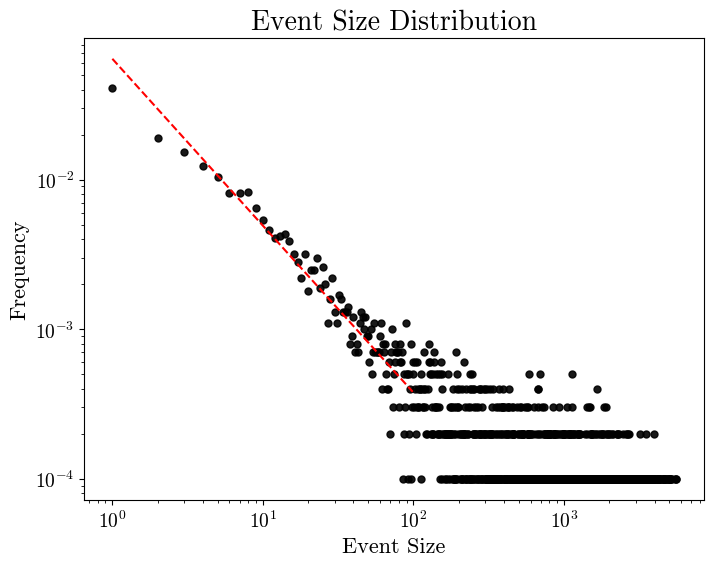

In [7]:
# Perform linear regression
fitted_size_sf = unique_sf[unique_sf < 100]
frequencies = counts_sf[unique_sf < 100]/num_samples
log_event_sizes = np.log(fitted_size_sf)
log_frequencies = np.log(frequencies)
slope, intercept, _, _, _ = linregress(log_event_sizes, log_frequencies)
fitted_line_sf = np.exp(intercept) * fitted_size_sf ** slope

# Plot the results
plt.figure(figsize=(8, 6))
plt.loglog(unique_sf, counts_sf/num_samples, 'o', markersize=5, color='k', alpha=0.9)
plt.loglog(fitted_size_sf, fitted_line_sf, linestyle='--', color='red')
plt.xlabel('Event Size')
plt.ylabel('Frequency')
plt.title('Event Size Distribution')
plt.grid(False)
plt.savefig('DSFFM_eventSize_log.png', dpi=300)

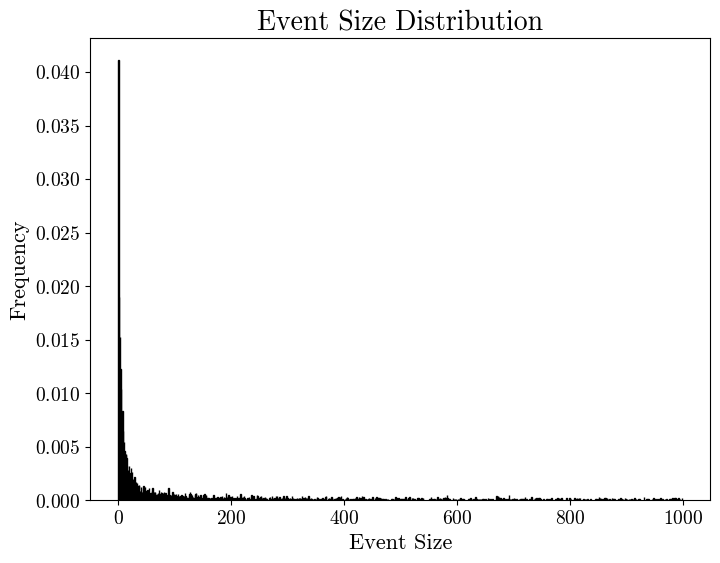

In [8]:
# Plot the results as histogram
plt.figure(figsize=(8, 6))
plt.bar(unique_sf[unique_sf<1000], counts_sf[unique_sf<1000]/num_samples, width=0.8, edgecolor='black', color='black') # set cutoff at 1000 for clearer visualisation
plt.xlabel('Event Size')
plt.ylabel('Frequency')
plt.title('Event Size Distribution')
plt.grid(False)
plt.savefig('DSFFM_eventSize.png', dpi=300)

## Modelling - correlation length

In [9]:
def compute_radius_of_gyration(coords):
    com = np.mean(coords, axis=0)  # Center of mass
    r_squared = np.sum(np.sum((coords - com) ** 2, axis=1)) / len(coords)
    return r_squared

def compute_correlation_length(lattice):
    clusters, num_clusters = label(lattice)
    ns = {}  # Cluster size to count mapping
    Rs_squared = {}  # Cluster size to sum of Rs^2 mapping

    for i in range(1, num_clusters + 1):
        coords = np.column_stack(np.where(clusters == i))
        size = len(coords)
        Rs2 = compute_radius_of_gyration(coords)
        
        if size in ns:
            ns[size] += 1
            Rs_squared[size] += Rs2
        else:
            ns[size] = 1
            Rs_squared[size] = Rs2

    # Compute xi^2
    numerator = sum(2 * Rs_squared[s] * s**2 * ns[s] for s in ns)
    denominator = sum(s**2 * ns[s] for s in ns)
    
    xi_squared = numerator / denominator if denominator != 0 else 0
    xi = np.sqrt(xi_squared)

    return xi

def simulate_correlation_length(L, p, f, steps, transient):
    # Define values
    xi_values = []
    
    # Initialize the lattice
    lattice = np.zeros((L, L), dtype=int)
    
    for k in range(steps):
        lattice = update_lattice(lattice, p, f)
        if k > transient:
            xi = compute_correlation_length(lattice == BURNING)
            xi_values.append(xi)
    return np.mean(xi_values)

# Running simulations in parallel
def run_single_simulation(p):
    return simulate_correlation_length(L, p, f, steps, transient)

In [10]:
# Average xi directly
L = 100  # Lattice size
ps = np.concatenate((np.linspace(0.0002, 0.002, 30), np.linspace(0.002, 0.02, 30), np.linspace(0.02, 0.99, 30)))   # Probability of tree growth
f = 0.0002  # Probability of lightning strike
steps = 8000  # Simulation steps
num_sims = 10
transient = 7000
results = np.zeros(len(ps))

# Perform simulations
all_results = Parallel(n_jobs=-1)(delayed(run_single_simulation)(p) for _ in range(num_sims) for p in ps)

# Reshape and average results
all_results = np.array(all_results).reshape(num_sims, len(ps))
results = all_results.mean(axis=0)

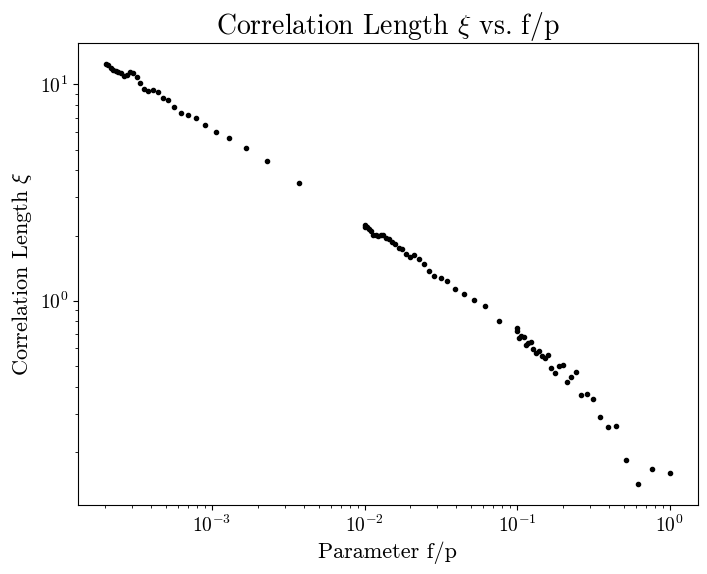

In [11]:
# Plot correlation length vs. p
plt.figure(figsize=(8, 6)) 
plt.loglog(f/ps, results, '.', color='k')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Parameter f/p')
plt.ylabel(r'Correlation Length $\xi$')
plt.title(r'Correlation Length $\xi$ vs. f/p')
plt.savefig('DSFFM_corrLen.png', dpi=300)